In [1]:
import json
import os
from pathlib import Path
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import json
import pandas as pd

import json
import pandas as pd
import glob
import re

from pandas import DataFrame


class KabaddiDataAPI:
    def __init__(self):
        self.base_path = "./MatchData_pbp"
    # for a season - display the standings

    def internal_create_matches_list(self, team, group_name):
        matches = []
        for match in team['match_result']['match']:
            match_info = {
                'Group': group_name,
                'match_id': match['id'],
                'date': match['date'],
                'teama_id': match['teama_id'],
                'result': match['result'],
                'teama_short_name': match['teama_short_name'],
                'teama_score': match['teama_score'],
                'teamb_id': match['teamb_id'],
                'teamb_short_name': match['teamb_short_name'],
                'teamb_score': match['teamb_score'],
                'match_result': match['match_result']
            }

            print(match_info)
            matches.append(match_info)
        return matches

    def internal_process_matches(self, matches_list):
        matches_df = pd.DataFrame(matches_list)
        matches_df = matches_df[(matches_df['result'].isin(['W', 'T'])) | (matches_df['result'].isnull())]
        matches_df = matches_df.sort_values(by='date', ascending=True)
        matches_df = matches_df.set_index('match_id').rename_axis('match id')
        return matches_df





    # DEPRECIATED
    def get_pkl_standings_matches(self, season=None, qualified=False, team_id=None, matches=False):

        if season is None:
            season = 10

        file_path = Path(f"./PKL_Standings/pkl_standings_s{season}.json")

        with open(file_path, 'r') as f:
            data = json.load(f)

        standings = data['standings']

        team_standings_info_list, qualified_teams_info_df, matches_list, = [], [], []

        season_name = standings['series_name']
        champion_team_id = standings['champion_id']

        if len(standings['groups']) == 0:
            return pd.DataFrame()

        if len(standings['groups']) == 1:

            group = standings['groups'][0]
            if 'name' in group and group['name'] != "":
                group_name = group['name']
            else:
                group_name = 'Main'

            for team in group['teams']['team']:
                if team_id is None or int(team['team_id']) == team_id:
                    team_standings_info = {
                        'Group': group_name,
                        'Season': season,
                        'Team_Id': team['team_id'],
                        'Team_Name': team['team_name'],
                        # 'team_short_name': team['team_short_name'],
                        'League_position': team['position'],
                        'Matches_played': team['played'],
                        'Wins': team['wins'],
                        'Lost': team['lost'],
                        'Tied': team['tied'],
                        'Draws': team['draws'],
                        'No Result': team['noresult'],
                        'League_points': team['points'],
                        'Score_diff': team['score_diff'],
                        'Qualified': team['is_qualified'],
                    }

                    if qualified and team['is_qualified']:
                        qualified_teams_info_df.append(team_standings_info)

                    team_standings_info_list.append(team_standings_info)

                    if matches:
                        matches_list.extend(self.internal_create_matches_list(team, group_name))

        else:

            for group in standings['groups']:

                if 'name' in group and group['name'] != "":
                    group_name = group['name']
                else:
                    group_name = 'Main'

                for team in group['teams']['team']:
                    if team_id is None or int(team['team_id']) == team_id:
                        team_info = {
                            'Group': group_name,
                            'Season': season,
                            'Team_Id': team['team_id'],
                            'Team_Name': team['team_name'],
                            # 'team_short_name': team['team_short_name'],
                            'League_position': team['position'],
                            'Matches_played': team['played'],
                            'Wins': team['wins'],
                            'Lost': team['lost'],
                            'Tied': team['tied'],
                            'Draws': team['draws'],
                            'No Result': team['noresult'],
                            'League_points': team['points'],
                            'Score_diff': team['score_diff'],
                            'Qualified': team['is_qualified'],
                        }

                        if qualified and team['is_qualified']:
                            qualified_teams_info_df.append(team_info)

                        team_standings_info_list.append(team_info)

                        if matches:
                            matches_list.extend(self.internal_create_matches_list(team, group_name))

        team_info_df = pd.DataFrame(team_standings_info_list)

        if qualified:
            qualified_teams_df = pd.DataFrame(qualified_teams_info_df)
            return qualified_teams_df, team_info_df

        if matches:
            matches_df = self.internal_process_matches(matches_list)
            return team_info_df, matches_df

        else:
            return team_info_df


    def get_pkl_standings(self, season=None, qualified=False, team_id=None):
        
        if season is None:
            season = 10

        file_path = Path(f"./PKL_Standings/pkl_standings_s{season}.json")

        with open(file_path, 'r') as f:
            data = json.load(f)

        standings = data['standings']
        team_standings_info_list, qualified_teams_standings_info_list = [], []

        if len(standings['groups']) == 0:
            return pd.DataFrame()

        def process_team(group_name, team):
            team_info = {
                'Group': group_name,
                'Season': season,
                'Team_Id': team['team_id'],
                'Team_Name': team['team_name'],
                'League_position': team['position'],
                'Matches_played': team['played'],
                'Wins': team['wins'],
                'Lost': team['lost'],
                'Tied': team['tied'],
                'Draws': team['draws'],
                'No Result': team['noresult'],
                'League_points': team['points'],
                'Score_diff': team['score_diff'],
                'Qualified': team['is_qualified'],
            }

            if (team_id is None or int(team['team_id']) == team_id):
                team_standings_info_list.append(team_info)
                if qualified and team['is_qualified']:
                    qualified_teams_standings_info_list.append(team_info)

        for group in standings['groups']:
            if 'name' in group and group['name'] != "":
                group_name = group['name']
            else:
                group_name = 'Main'
            for team in group['teams']['team']:
                process_team(group_name, team)

        team_info_df = pd.DataFrame(team_standings_info_list)

        if qualified:
            qualified_teams_df = pd.DataFrame(qualified_teams_standings_info_list)
            return qualified_teams_df, team_info_df

        return team_info_df


    def get_season_matches(self, season="all"):
        
        matches_list = []

        # Determine the file(s) to load based on the season input
        if season == "all":
            files = glob.glob('./Matches-Overview/S*_PKL_MatchData.json')
            # Sort the files based on the season number
            files = sorted(files, key=lambda x: int(re.search(r'S(\d+)', x).group(1)))
            print(files)

        else:
            files = [f'./Matches-Overview/S{season}_PKL_MatchData.json']

        for file in files:
            
            with open(file) as f:
                data = json.load(f)


            for match in data['matches']:

                team_name, team_id, team_score = [], [], []

                for p in match['participants']:
                    # print(p['name'])
                    team_name.append(p['name'])
                    team_id.append(p['id'])
                    team_score.append(p['value'])


                match_details = {
                    "Season": match['tour_name'].split(",")[0].split(" ")[-1],
                    'Match_ID': match['game_id'],
                    "Match_Name": match['event_name'],
                    "League_Stage": match['event_stage'],
                    "Year": match['tour_name'].split(",")[1].strip(),
                    "Venue": match['venue_name'].lower().title().strip(),
                    'Match_Outcome': match['event_sub_status'],
                    "Start_Date": match['start_date'],
                    "End_Date": match['end_date'],
                    "Result": match['result_code'],
                    "Winning Margin": match['winning_margin'],
                    'team_score_1': team_score[0],
                    'team_score_2': team_score[1],
                    'team_name_1': team_name[0],
                    'team_id_1': team_id[0],
                    'team_name_2': team_name[1],
                    'team_id_2': team_id[1],
                }

                

                matches_list.append(match_details)

        # Convert the list of dictionaries into a DataFrame
        df = pd.DataFrame(matches_list)

        df.to_csv("matches_data.csv")

        # Display the DataFrame
        return df


    def get_team_info(self, team_id, season='overall'):
        """
            Retrieve comprehensive information for a specific team in a given season or overall.

            Parameters:
            team_id : int
                The unique identifier for the team.
            season : str or int, optional
                The season for which to retrieve team information.
                Use 'overall' for aggregated stats across all seasons (default),

            Returns:
            tuple of pandas.DataFrame or None
                A tuple containing five elements:
                1. df_rank: Team's rankings in various categories
                2. df_value: Team's raw statistic values
                3. df_per_match: Team's per-match statistics
                4. filtered_team_raider_skills: Team's raider skill statistics (None for 'overall')
                5. filtered_team_defender_skills: Team's defender skill statistics (None for 'overall')

                Returns (None, None, None, None, None) if no data is found for the specified team and season.
    """


        if season != 'overall':
            season = int(season)
        
        df_team_aggregated_stats = pd.read_csv("./Team-Wise-Data/PKL_AggregatedTeamStats.csv")
        df_team_raider_skills = pd.read_csv("./Team-Wise-Data/ALL_Raider_Skills_Merged.csv")
        df_team_defender_skills = pd.read_csv("./Team-Wise-Data/ALL_Defensive_Skills_Merged.csv")

        team_id = int(team_id)

        def find_team_column(dataframe, team_id):
            for col in dataframe.columns:
                if f"({team_id})" in col:
                    return col
            return None
        team_column_team_raider_skills = find_team_column(df_team_raider_skills, team_id)
        team_column_team_defender_skills = find_team_column(df_team_defender_skills, team_id)
        
        

        if season == 'overall':

            filtered_team_aggregated_stats = df_team_aggregated_stats[df_team_aggregated_stats['team_id'] == team_id]
            
            rows_overall = filtered_team_aggregated_stats[filtered_team_aggregated_stats['season'] == 'all']
            other_rows = filtered_team_aggregated_stats[filtered_team_aggregated_stats['season'] != 'all']

            filtered_team_aggregated_stats = pd.concat([rows_overall, other_rows]).reset_index(drop=True)
            filtered_team_raider_skills = None
            filtered_team_defender_skills = None

        
        else:

            df_team_aggregated_stats['team_id'] = pd.to_numeric(df_team_aggregated_stats['team_id'], errors='coerce')
            df_team_aggregated_stats['season'] = pd.to_numeric(df_team_aggregated_stats['season'], errors='coerce')
            
            filtered_team_aggregated_stats = df_team_aggregated_stats[df_team_aggregated_stats['season'] == season]
            filtered_team_aggregated_stats = filtered_team_aggregated_stats[filtered_team_aggregated_stats['team_id'] == team_id]

            if team_column_team_raider_skills:            
                filtered_team_raider_skills = df_team_raider_skills[df_team_raider_skills['Season'] == season]
                filtered_team_raider_skills = filtered_team_raider_skills[['Season','Skill Type','Skill Name',team_column_team_raider_skills]].reset_index(drop=True)
            else:
                filtered_team_raider_skills = None


            if team_column_team_defender_skills:
                filtered_team_defender_skills = df_team_defender_skills[df_team_defender_skills['Season'] == season]
                filtered_team_defender_skills = filtered_team_defender_skills[['Season','Skill Type','Skill Name',team_column_team_defender_skills]].reset_index(drop=True)
            else:
                filtered_team_defender_skills = None

        if filtered_team_aggregated_stats.empty:
            print(f"No data found in CSV for team_id {team_id} in season {season}")
            return None, None, None, None, None
        

        rank_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_rank')]
        value_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_value')]
        per_match_columns = [col for col in filtered_team_aggregated_stats.columns if col.endswith('_per-match')]

        # print(f"len rank cols: {len(rank_columns)}")
        # print(f"len value cols: {len(value_columns)}")
        # print(f"len per match cols: {len(per_match_columns)}")

        df_rank = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + rank_columns]
        df_value = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + value_columns]
        df_per_match = filtered_team_aggregated_stats[['season', 'team_id', 'team_name' , 'matches_played'] + per_match_columns]


        if season == 'overall':
            return df_rank, df_value, df_per_match, filtered_team_raider_skills, filtered_team_defender_skills
        else:
            return df_rank.T, df_value.T, df_per_match.T, filtered_team_raider_skills, filtered_team_defender_skills
            


    def get_team_matches(self, season, team_id :str):
        """
            Retrieve all matches for a specific team in a given season.

            Parameters:
            season : int
                The season number for which to retrieve matches.
            team_id : str
                The unique identifier for the team, as a string.

            Returns:
            pandas.DataFrame
                A DataFrame containing all matches in the specified season where the given team
                participated, either as team 1 or team 2.
        """
        df = self.get_season_matches(season=season)

        team_id = str(team_id)
        df = df[(df['team_id_1'] == team_id) | (df['team_id_2'] == team_id)]


        # print(df.columns)
        return df

        # matches_list = []

        # # Determine the file(s) to load based on the season input
        # if season == "all":
        #     files = glob.glob('./Matches-Overview/S*_PKL_MatchData.json')
        # else:
        #     files = [f'./Matches-Overview/S{season}_PKL_MatchData.json']

        # for file in files:
        #     with open(file) as f:
        #         data = json.load(f)

        #     # Loop over each match in the file
        #     for match in data['matches']:
        #         if match['participants'][0]['id']==team_id or  match['participants'][1]['id']==team_id:
        #             match_details = {
        #                 "Match Name": match['event_name'],
        #                 'Match ID': match['game_id'],
        #                 "Tour Name": match['tour_name'],
        #                 "Venue": match['venue_name'],
        #                 'Match_Outcome': match['event_sub_status'],
        #                 "Date": match['start_date'],
        #                 "Result": match['event_sub_status'],
        #                 "Winning Margin": match['winning_margin']
        #             }
        #             matches_list.append(match_details)
        #     df = pd.DataFrame(matches_list)
        #     return df
    

    def build_team_roster(self, team_id, season):
        """
            Build a roster for a specific team in a given season.

            Parameters:
            team_id : int
                The unique identifier for the team.
            season : int
                The season number for which to build the roster.

            Returns:
            pandas.DataFrame
                A DataFrame containing the roster information with the following columns:
                - Player ID
                - Name
                - Jersey Number
                - Captain Count
                - Played Count
                - Green Card Count
                - Yellow Card Count
                - Red Card Count
                - Starter Count
                - Top Raider Count
                - Top Defender Count
                - Total Points
                - Team ID
                - Team Name
                - Total Matches in Season
"""
        roster = {}
        team_id = int(team_id)
        team_name = ""
        total_matches = 0

        for folder_name in os.listdir("./MatchData_pbp"):
            if f"Season_{season}" in folder_name:
                directory_path = os.path.join("./MatchData_pbp", folder_name)
                break
        else:
            print(f"No data found for season {season}")
            return pd.DataFrame()

        for filename in os.listdir(directory_path):
            if filename.endswith(".json"):
                file_path = os.path.join(directory_path, filename)
                with open(file_path, 'r') as f:
                    match_data = json.load(f)

                if 'gameData' in match_data:
                    match_data = match_data['gameData']

                series_dict = {10: '44', 9: '25', 8: '20', 7: '11', 6: '10', 5: '8', 3: '3', 2: '2', 1: '1', 4: '4'}
                season_id = series_dict.get(int(season))

                if int(match_data['match_detail']['series']['id']) == int(season_id):
                    for team in match_data['teams']['team']:
                        if int(team['id']) == team_id:
                            total_matches += 1
                            team_name = team['name']
                            for player in team['squad']:
                                player_id = player['id']
                                if player_id not in roster:
                                    roster[player_id] = {
                                        'Player ID': player_id,
                                        'Name': player['name'],
                                        'Jersey Number': player.get('jersey'),
                                        #'Skill': player.get('skill'),
                                        'Captain Count': 0,
                                        'Played Count': 0,
                                        'Green Card Count': 0,
                                        'Yellow Card Count': 0,
                                        'Red Card Count': 0,
                                        'Starter Count': 0,
                                        'Top Raider Count': 0,
                                        'Top Defender Count': 0,
                                        'Total Points': 0,
                                        'Team ID': team_id,
                                        'Team Name': team_name
                                    }
                                
                                roster[player_id]['Captain Count'] += int(player.get('captain', False))
                                roster[player_id]['Played Count'] += int(player.get('played', False))
                                roster[player_id]['Green Card Count'] += int(player.get('green_card', False))
                                roster[player_id]['Yellow Card Count'] += int(player.get('yellow_card', False))
                                roster[player_id]['Red Card Count'] += int(player.get('red_card', False))
                                roster[player_id]['Starter Count'] += int(player.get('starter', False))
                                roster[player_id]['Top Raider Count'] += int(player.get('top_raider', False))
                                roster[player_id]['Top Defender Count'] += int(player.get('top_defender', False))
                                roster[player_id]['Total Points'] += player.get('points', {}).get('total', 0)

        roster_df = pd.DataFrame(list(roster.values()))
        roster_df['Total Matches in Season'] = total_matches
        return roster_df


    def get_player_info(self, player_id, season=None):
        """
            Retrieve comprehensive information for a specific player in a given season.

            Parameters:
            player_id : int
                The unique identifier for the player.
            season : int, optional
                The season number for which to retrieve player information. Uses the latest available season by default.

            Returns:
            tuple of pandas.DataFrame
                A tuple containing four DataFrames:
                1. player_stats_df_rank: Player's rankings in various categories
                2. player_stats_df_value: Player's raw statistic values
                3. player_stats_df_per_match: Player's per-match statistics
                4. rvd_extracted_df: Player's performance against different numbers of defenders
"""
        player_id = int(player_id)
        file_path = "./Player-Wise-Data/all_seasons_player_stats_rounded.csv"
        df = pd.read_csv(file_path)

        file_rvd = Path(r"./Player-Wise-Data/merged_raider_v_num_defenders_FINAL.csv")
        rvd_df = pd.read_csv(file_rvd)

        defend_file = "./Player-Wise-Data/AllSeasons_AllTeams_DefenderSuccessRate.csv"
        defend_df = pd.read_csv(defend_file)

        raider_file = "./Player-Wise-Data/AllSeasons_AllTeams_RaiderSuccessRate.csv"
        raider_df = pd.read_csv(raider_file)

        player_starts = "./Player-Wise-Data/Player_Team_Lineup_merged.csv"
        player_starts_df = pd.read_csv(player_starts)

        def to_numeric_or_nan(x):
            try:
                return pd.to_numeric(x)
            except ValueError:
                return np.nan

        df['player_id'] = df['player_id'].apply(to_numeric_or_nan)
        df['player_id'] = df['player_id'].fillna(-1)
        df['player_id'] = df['player_id'].astype(np.int64)

        rvd_df['player-id'] = rvd_df['player-id-pkdc-sanitised'].apply(to_numeric_or_nan)
        rvd_df['player-id'] = rvd_df['player-id'].fillna(-1)
        rvd_df['player-id'] = rvd_df['player-id'].astype(int)


        defend_df['player_id'] = defend_df['player_id_copy_backup'].apply(to_numeric_or_nan)
        defend_df['player_id'] = defend_df['player_id'].fillna(-1)
        defend_df['player_id'] = defend_df['player_id'].astype(np.int64)

        raider_df['player_id'] = raider_df['player-id-clean'].apply(to_numeric_or_nan)
        raider_df['player_id'] = raider_df['player_id'].fillna(-1)
        raider_df['player_id'] = raider_df['player_id'].astype(np.int64)

        player_starts_df['player_id'] = player_starts_df['player_id_clean'].apply(to_numeric_or_nan)
        player_starts_df['player_id'] = player_starts_df['player_id'].fillna(-1)
        player_starts_df['player_id'] = player_starts_df['player_id'].astype(np.int64)

        # If season is not specified, use the latest season
        if season is None:
            season = df['season'].max()

        # Player aggregated stats
        player_stats_df = df[(df['player_id'] == player_id) & (df['season'] == season)]

        if player_stats_df.empty:
            print(f"No data for player {player_id} for season {season} |  AGGREGATED")

        player_starts_df = player_starts_df[(player_starts_df['player_id'] == player_id) & (player_starts_df['season_num'] == season)]
        if player_starts_df.empty:
            print(f"No data for player {player_id} for season {season} |  STARTS")

        # Raiders v defenders
        rvd_data = rvd_df[rvd_df['player-id'] == player_id]
        if rvd_data.empty:
            print(f"No data for raiders v no of defenders for {player_id}")
        
        rvd_extracted_df = rvd_data[rvd_data['season'].str.extract(r'(\d+)')[0].astype(int) == season]
        if rvd_extracted_df.empty:
            print(f"No data for raiders v no of defenders for {player_id} for season {season}")


        defend_extracted_df = defend_df[(defend_df['player_id'] == player_id) & (defend_df['season'] == season)]
        if defend_extracted_df.empty:
            print(f"No data for defenders for {player_id} for season {season}")
        
        raider_extracted_df = raider_df[(raider_df['player_id'] == player_id) & (raider_df['season'] == season)]
        if raider_extracted_df.empty:
            print(f"No data for raiders for {player_id} for season {season}")
        
        player_stats_df_rank = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_rank", "player-raid-points_rank", "player-super-raids_rank", "player-high-5s_rank", "player-tackle-points_rank", "player-avg-tackle-points_rank", "player-dod-raid-points_rank", "player-total-points_rank", "player-successful-tackles_rank", "player-successful-raids_rank", "super-10s_rank" ]].copy()
                                                
        player_stats_df_value = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_value", "player-raid-points_value", "player-super-raids_value", "player-high-5s_value", "player-tackle-points_value", "player-avg-tackle-points_value", "player-dod-raid-points_value", "player-total-points_value", "player-successful-tackles_value", "player-successful-raids_value", "super-10s_value"]].copy()
                                    
        player_stats_df_per_match = player_stats_df[["season", "player_id", "player_name", "player_matches_played", "player_position_id", "player_position_name", "team_id", "team_full_name", "player-super-tackles_points_per_match", "player-raid-points_points_per_match", "player-super-raids_points_per_match", "high-5s_points_per_match", "player-tackle-points_points_per_match", "player-dod-raid-points_points_per_match", "player-total-points_points_per_match", "player-successful-tackles_points_per_match", "player-successful-raids_points_per_match", "super-10s_points_per_match"]].copy()


        if not defend_extracted_df.empty:
            defend_data = defend_extracted_df.iloc[0]
            player_stats_df_value['Total Tackles'] = defend_data.get('Total Tackles', np.nan)
            player_stats_df_value['Successful Tackles'] = defend_data.get('Successful Tackles', np.nan)
            player_stats_df_value['Defender Success Rate'] = defend_data.get('Defender Success rate', np.nan)


        if not raider_extracted_df.empty:
            raider_data = raider_extracted_df.iloc[0]
            player_stats_df_value['Total Raids'] = raider_data.get('Total Raids', np.nan)
            player_stats_df_value['Successful Raids'] = raider_data.get('Successful Raids', np.nan)
            player_stats_df_value['Raider Success Rate'] = raider_data.get('Raider Success Rate', np.nan)

        if not player_starts_df.empty:
            player_starts_data = player_starts_df.iloc[0]
            player_stats_df_value['Total Played'] = player_starts_data.get('Total Played', np.nan)
            player_stats_df_value['Total Starts'] = player_starts_data.get('Total Starts', np.nan)

        rvd_extracted_df = rvd_extracted_df[['Season_Number', 'Team Name',
                                            'player-id', 'Raider Name', 'Number of Defenders', 'Total Raids',
                                            'Percentage of Raids', 'Empty Raids Percentage',
                                            'Successful Raids Percentage']]
        
        

        return player_stats_df_rank.T, player_stats_df_value.T, player_stats_df_per_match.T, rvd_extracted_df.T


    def load_match_details(self, season, match_id) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
        """
        Get the full data for a specific match.

        Args:
            season (str): The season name.
            match_id (str): The match ID.

        Returns:
            Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
            A tuple containing match detail, teams, events, zones, team1, and team2 DataFrames.
        """

        # print(f"Loading match details for season {season} and match ID {match_id}")

        for dir in os.listdir(self.base_path):
            if f"Season_PKL_Season_{season}" in dir:
                season_path = os.path.join(self.base_path, dir)
                break
        else:
            raise ValueError(f"No season data found for season {season}")
        
        file_name = next((f for f in os.listdir(season_path) if f.endswith(f'_ID_{match_id}.json')), None)

        if not file_name:
            raise FileNotFoundError(f"No match file found for season {season} and match ID {match_id}")

        file_path = os.path.join(season_path, file_name)

        try:
            with open(file_path, 'r') as file:
                temp = json.load(file)

            # Check if the data is nested under 'gameData'
            if 'gameData' in temp:
                temp = temp['gameData']

            match_detail = temp.get("match_detail", {})
            flattened_match_detail = self._flatten_match_detail(match_detail)
            # print(f"Flattened match detail: {flattened_match_detail}")
            # print(f"Flattened match detail columns: {flattened_match_detail.keys()}")
            # print("-"*100)
            # print(f"Match detail: {match_detail}")
            match_detail_df = pd.DataFrame([flattened_match_detail])

            events_df = pd.DataFrame(temp.get("events", {}).get("event", []))
            zones_df = pd.DataFrame(temp.get("zones", {}).get("zone", []))

            teams_data = temp.get("teams", {}).get("team", [])

            if len(teams_data) != 2:
                raise ValueError("Expected data for exactly two teams")

            team1_df, team2_df = self._process_team_data(teams_data)
            teams_df = pd.DataFrame(teams_data)

            return match_detail_df, teams_df, events_df, zones_df, team1_df, team2_df

        except Exception as e:
            print(f"Error loading data from {file_path}: {str(e)}")
            return None, None, None, None, None, None

    
    def load_pbp_data(self, season, match_id) -> DataFrame:
        """
        Get all events for a specific match.

        Args:
            season (str): The season name.
            match_id (str): The match ID.

        Returns:
            DataFrame: A DataFrame containing all events in the match.
        """
        _, _, events_df, _, _, _ = self.load_match_details(season, match_id)
        return events_df


    def _flatten_match_detail(self, match_detail: Dict[str, Any]) -> Dict[str, Any]:
        """
        Flatten nested dictionaries in match detail.

        Args:
            match_detail (Dict[str, Any]): The match detail dictionary.

        Returns:
            Dict[str, Any]: Flattened match detail dictionary.
        """
        flattened = {}
        for key, value in match_detail.items():
            if isinstance(value, dict):
                for subkey, subvalue in value.items():
                    flattened[f"{key}_{subkey}"] = subvalue

            elif isinstance(value, list):
                if key == "player_of_the_match":
                    flattened[f"{key}_id"] = value[0].get("id") if value else None
                    flattened[f"{key}_value"] = value[0].get("value") if value else None
                else:
                    flattened[key] = json.dumps(value)
            else:
                flattened[key] = value
        return flattened

    def _process_team_data(self, teams_data: List[Dict[str, Any]]) -> Tuple[DataFrame, DataFrame]:
        """
        Process team data into DataFrames.

        Args:
            teams_data (List[Dict[str, Any]]): List containing data for both teams.

        Returns:
            Tuple[DataFrame, DataFrame]: DataFrames for team1 and team2.
        """

        def process_squad(squad_data):
            processed_squad = []
            for player in squad_data:
                player_dict = {
                    'id': player['id'],
                    'name': player['name'],
                    'jersey': player.get('jersey', ''),
                    'played': player.get('played', False),
                    'captain': player.get('captain', False),
                    'on_court': player.get('on_court', False),
                    'starter': player.get('starter', False),
                    'red_card': player.get('red_card', False),
                    'yellow_card': player.get('yellow_card', False),
                    'green_card': player.get('green_card', False),
                    'red_card_count': player.get('red_card_count', 0),
                    'yellow_card_count': player.get('yellow_card_count', 0),
                    'green_card_count': player.get('green_card_count', 0),
                    'top_raider': player.get('top_raider', False),
                    'top_defender': player.get('top_defender', False),
                    'total_points': player.get('points', {}).get('total', 0),
                    'raid_points': player.get('points', {}).get('raid_points', {}).get('total', 0),
                    'tackle_points': player.get('points', {}).get('tackle_points', {}).get('total', 0),
                    'raids_total': player.get('raids', {}).get('total', 0),
                    'raids_successful': player.get('raids', {}).get('successful', 0),
                    'tackles_total': player.get('tackles', {}).get('total', 0),
                    'tackles_successful': player.get('tackles', {}).get('successful', 0),
                }
                for zone_type in ['strong_zones', 'weak_zones']:
                    for zone in player.get(zone_type, {}).get(zone_type.rstrip('s'), []):
                        player_dict[f"{zone_type}_zone_{zone['zone_id']}"] = zone['points']
                processed_squad.append(player_dict)
            return processed_squad

        team1_df = pd.DataFrame(process_squad(teams_data[0].get('squad', [])))
        team2_df = pd.DataFrame(process_squad(teams_data[1].get('squad', [])))

        for team_df, team_data in zip([team1_df, team2_df], teams_data):
            team_df['team_id'] = team_data['id']
            team_df['team_name'] = team_data['name']
            team_df['team_score'] = team_data['score']
            team_df['team_short_name'] = team_data['short_name']

        return team1_df, team2_df









# # Usage example


In [3]:
api = KabaddiDataAPI()

In [6]:
api.get_pkl_standings(season=7)

FileNotFoundError: [Errno 2] No such file or directory: 'PKL_Standings\\pkl_standings_s7.json'

In [24]:
df_rank, df_value, df_per_match, filtered_team_raider_skills, filtered_team_defender_skills = api.get_team_info(team_id=5, season='7')

In [25]:
df_value.T[['team-total-points_value']]

,team-total-points_value
60,785


## raider vs defenders viz

In [5]:
api.build_team_roster(1,7)

No data found for season 7


""


## PASTING VISUALIZATION CODE

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Circle
import json
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Circle, Wedge
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm



def load_json_data(file_path):
    with open(file_path, 'r') as file:
        return json.loads(file.read())


# def get_zone_coordinates(zone_id, court_width, court_length):
#     zones = {
#         1: (0.5, court_length / 2),  # Left Lobby
#         2: (court_width - 0.5, court_length / 2),  # Right Lobby
#         3: (court_width / 4, court_length - 0.5),  # Midline Left
#         4: (court_width / 2, court_length - 0.5),  # Midline Centre
#         5: (3 * court_width / 4, court_length - 0.5),  # Midline Right
#         6: (court_width / 4, (3 * court_length / 4) - 0.5),  # Baulk Left
#         7: (court_width / 2, (3 * court_length / 4) - 0.5),  # Baulk Centre
#         8: (3 * court_width / 4, (3 * court_length / 4) - 0.5),  # Baulk Right
#         9: (court_width / 4, 0.5),  # Bonus Left
#         10: (court_width / 2, 0.5),  # Bonus Centre
#         11: (3 * court_width / 4, 0.5),  # Bonus Right
#     }
#     return zones.get(zone_id, (court_width / 2, court_length / 2))


def aggregate_player_data(directory_path, player_id):
    player_data = None
    strong_zones = {i: 0 for i in range(1, 12)}
    weak_zones = {i: 0 for i in range(1, 12)}

    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            data = load_json_data(file_path)
            data = data['gameData']
            teams = data['teams']['team']
            for team in teams:
                for player in team['squad']:
                    if player['id'] == player_id:
                        if not player_data:
                            player_data = player

                        for zone in player['strong_zones']['strong_zone']:
                            strong_zones[zone['zone_id']] += zone['points']
                            # print(strong_zones)

                        for zone in player['weak_zones']['weak_zone']:
                            weak_zones[zone['zone_id']] += zone['points']


    return player_data, strong_zones, weak_zones


def plot_player_zones(directory_path, player_id, zone_type='strong'):
    player_data, strong_zones, weak_zones = aggregate_player_data(directory_path, player_id)

    if not player_data:
        print(f"Player with ID {player_id} not found in any match data.")
        return

    fig, ax = plt.subplots(figsize=(15, 12))
    court_width, court_length = 13, 10

    court_color = '#4169E1'  # Royal Blue
    lobby_color = '#B22222'  # Firebrick Red

    # Draw court (main play area)
    ax.add_patch(Rectangle((1, 0), court_width - 2, court_length / 2, fill=True, color=court_color))

    # Draw lobbies
    ax.add_patch(Rectangle((0, 0), 1, court_length / 2, fill=True, color=lobby_color))
    ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length / 2, fill=True, color=lobby_color))

    # Draw lines
    line_color = 'white'
    ax.axhline(y=court_length / 2, color=line_color, linewidth=2)
    ax.axhline(y=3.75, color=line_color, linewidth=2)
    ax.axhline(y=1, color=line_color, linewidth=2)

    ax.text(court_width / 2, court_length / 2, 'Mid Line', ha='center', va='center', color='black', fontsize=14)
    ax.text(court_width / 2, 3.75, 'Baulk Line', ha='center', va='bottom', color='black', fontsize=14)
    ax.text(court_width / 2, 1, 'Bonus Line', ha='center', va='bottom', color='black', fontsize=14)
    ax.text(0.5, (court_length / 4) - 0.2, 'Left Lobby', ha='center', va='center', color='black', fontsize=14)
    ax.text(court_width - 0.5, (court_length / 4) - 0.2, 'Right Lobby', ha='center', va='center', color='black',
            fontsize=14)

    # Plot player position (center of the court for simplicity)
    player_x, player_y = court_width / 2, (court_length / 2) - 2.5
    ax.add_patch(Circle((player_x, player_y), 0.25, fill=True, color='yellow'))
    ax.text(player_x, player_y + 0.1, str(player_data['jersey']), ha='center', va='center', color='black', fontsize=14)
    ax.text(player_x + 0.01, player_y - 0.1, 'Jersey', ha='center', va='center', color='black', fontsize=12)

    # Plot heat map of selected zone type
    zones = strong_zones if zone_type == 'strong' else weak_zones
    max_points = max(zones.values())
    non_zero_values = filter(lambda x: x > 0, zones.values())
    min_points = min(non_zero_values, default=1)

    for zone_id, points in zones.items():
        if points > 0:
            zone_x, zone_y = get_zone_coordinates(zone_id, court_width, court_length / 2)
            color = 'green' if zone_type == 'strong' else 'red'
            intensity = points / max_points
            if zone_type == 'weak':
                intensity = min_points / points

            ax.add_patch(Rectangle((zone_x - 0.5, zone_y), 1, 0.5, fill=True, alpha=intensity, color=color))
            ax.text(zone_x, zone_y + 0.2, str(points), ha='center', va='center', color='white', fontsize=14)

    # Set title
    plt.title(f"{player_data['name']} - Season {zone_type.capitalize()} Zones", fontsize=16, pad=20)

    # Set axis limits and remove ticks
    ax.set_xlim(0, court_width)
    ax.set_ylim(0, court_length / 2)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()


def internal_plot_player_zones_improved(player_id, season, zone_type='strong',fig=None, ax=None):
    season_directories = {
        1: "Season_PKL_Season_1_2014", 2: "Season_PKL_Season_2_2015", 3: "Season_PKL_Season_3_2016", 4: "Season_PKL_Season_4_2016",
        5: "Season_PKL_Season_5_2017", 6: "Season_PKL_Season_6_2018", 7: "Season_PKL_Season_7_2019",
    }
    if season not in season_directories:
        raise ValueError(f"Invalid season number. Available seasons are: {list(season_directories.keys())}")

    directory_path = f"./MatchData_pbp/{season_directories[season]}"

    player_data, strong_zones, weak_zones = aggregate_player_data(directory_path, player_id)

    if not player_data:
        print(f"Player with ID {player_id} not recorded for any match data.")
        return

    #fig, ax = plt.subplots(figsize=(12, 8))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    court_width, court_length = 13, 10
    
    # Custom color schemes
    court_color = '#E6F3FF'  # Light blue for court
    lobby_color = '#FFE6E6'  # Light red for lobby
    line_color = '#333333'   # Dark gray for lines

    # Draw court (main play area)
    ax.add_patch(Rectangle((1, 0), court_width - 2, court_length, fill=True, color=court_color, ec=line_color, lw=2))

    # Draw lobbies
    ax.add_patch(Rectangle((0, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))
    ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length, fill=True, color=lobby_color, ec=line_color, lw=2))

    # Draw lines
    ax.axhline(y=court_length, color=line_color, linewidth=2)
    ax.axhline(y=3 * court_length / 4, color=line_color, linewidth=2)
    ax.axhline(y=1, color=line_color, linewidth=2)

    # Line Labels
    label_style = {'ha': 'center', 'va': 'center', 'color': line_color, 'fontsize': 10, 'fontweight': 'bold'}
    ax.text(court_width / 2, court_length + 0.2, 'Mid Line', **label_style)
    ax.text(court_width / 2, 3 * court_length / 4 + 0.2, 'Baulk Line', **label_style)
    ax.text(court_width / 2, 0.8, 'Bonus Line', **label_style)
    ax.text(0.5, court_length / 2, 'Left\nLobby', **label_style)
    ax.text(court_width - 0.5, court_length / 2, 'Right\nLobby', **label_style)

    # Plot player position
    player_x, player_y = court_width / 2, court_length / 2
    jersey_circle = Circle((player_x, player_y), 0.5, fill=True, facecolor='#FFD700', edgecolor=line_color, linewidth=2, zorder=10)
    ax.add_patch(jersey_circle)
    ax.text(player_x, player_y, str(player_data['jersey']), ha='center', va='center', color=line_color, fontsize=14, fontweight='bold', zorder=11)

    # Plot heat map of selected zone type
    zones = strong_zones if zone_type == 'strong' else weak_zones
    max_points = max(zones.values())
    non_zero_values = [v for v in zones.values() if v > 0]
    min_points = min(non_zero_values) if non_zero_values else 1

    # Custom color maps with increased contrast
    if zone_type == 'strong':
        colors = ['#E6FFE6', '#66FF66', '#00CC00', '#006400']
    else:
        colors = ['#FFE6E6', '#FF9999', '#FF3333', '#8B0000']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    # Plot zones
    for zone_id, points in zones.items():
        if points > 0:
            zone_x, zone_y = get_zone_coordinates(zone_id, court_width, court_length)
            intensity = (points - min_points) / (max_points - min_points)
            color = cmap(intensity)
            
            if zone_id in [1, 2]:  # Lobby zones
                if zone_id == 1:  # Left lobby
                    wedge = Wedge((1, court_length / 2), 0.9, 90, 270, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                else:  # Right lobby
                    wedge = Wedge((court_width - 1, court_length / 2), 0.9, 270, 90, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                ax.add_patch(wedge)
            else:  # Inner court zones
                circle = Circle((zone_x, zone_y), 0.9, fill=True, color=color, alpha=0.7, ec=line_color, lw=1, zorder=5)
                ax.add_patch(circle)
            
            ax.text(zone_x, zone_y, str(points), ha='center', va='center', color='white', fontsize=10, fontweight='bold', zorder=6)



    # Set axis limits and remove ticks
    ax.set_xlim(0, court_width)
    ax.set_ylim(0, court_length)
    ax.set_xticks([])
    ax.set_yticks([])

    # plt.tight_layout()
    #plt.show()
    return fig, ax


def get_zone_coordinates(zone_id, court_width, court_length):
    zones = {
        1: (0.5, court_length / 2),  # Left Lobby
        2: (court_width - 0.5, court_length / 2),  # Right Lobby
        3: (court_width / 4, court_length - 0.5),  # Midline Left
        4: (court_width / 2, court_length - 0.5),  # Midline Centre
        5: (3 * court_width / 4, court_length - 0.5),  # Midline Right
        6: (court_width / 4, (3 * court_length / 4) - 0.5),  # Baulk Left
        7: (court_width / 2, (3 * court_length / 4) - 0.5),  # Baulk Centre
        8: (3 * court_width / 4, (3 * court_length / 4) - 0.5),  # Baulk Right
        9: (court_width / 4, 0.5),  # Bonus Left
        10: (court_width / 2, 0.5),  # Bonus Centre
        11: (3 * court_width / 4, 0.5),  # Bonus Right
    }
    return zones.get(zone_id, (court_width / 2, court_length / 2))

def aggregate_team_data(directory_path, team_id):
    team_data = None
    team_id = str(team_id)
    strong_zones = {i: 0 for i in range(1, 12)}
    weak_zones = {i: 0 for i in range(1, 12)}

    for filename in os.listdir(directory_path):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            data = load_json_data(file_path)
            data = data['gameData']
            teams = data['teams']['team']
            for team in teams:
                if team['id'] == team_id:
                    if not team_data:
                        team_data = team

                    for player in team['squad']:
                        for zone in player['strong_zones']['strong_zone']:
                            strong_zones[zone['zone_id']] += zone['points']

                        for zone in player['weak_zones']['weak_zone']:
                            weak_zones[zone['zone_id']] += zone['points']

    return team_data, strong_zones, weak_zones


def plot_team_zones(team_id, season, zone_type='strong'):
    season_directories = {
        1: "Season_PKL_Season_1_2014", 2: "Season_PKL_Season_2_2015", 3: "Season_PKL_Season_3_2016",
        4: "Season_PKL_Season_4_2016",
        5: "Season_PKL_Season_5_2017", 6: "Season_PKL_Season_6_2018", 7: "Season_PKL_Season_7_2019",
    }
    if season not in season_directories:
        raise ValueError(f"Invalid season number. Available seasons are: {list(season_directories.keys())}")

    directory_path = f"./MatchData_pbp/{season_directories[season]}"

    team_data, strong_zones, weak_zones = aggregate_team_data(directory_path, team_id)
    team_id = str(team_id)
    if not team_data:
        print(f"Team with ID {team_id} not found in any match data.")
        return

    fig, ax = plt.subplots(figsize=(15, 12))
    court_width, court_length = 13, 10

    court_color = '#4169E1'  # Royal Blue
    lobby_color = '#B22222'  # Firebrick Red

    # Draw court (main play area)
    ax.add_patch(Rectangle((1, 0), court_width - 2, court_length / 2, fill=True, color=court_color))

    # Draw lobbies
    ax.add_patch(Rectangle((0, 0), 1, court_length / 2, fill=True, color=lobby_color))
    ax.add_patch(Rectangle((court_width - 1, 0), 1, court_length / 2, fill=True, color=lobby_color))

    # Draw lines
    line_color = 'white'
    ax.axhline(y=court_length / 2, color=line_color, linewidth=2)
    ax.axhline(y=3.75, color=line_color, linewidth=2)
    ax.axhline(y=1, color=line_color, linewidth=2)

    ax.text(court_width / 2, court_length / 2, 'Mid Line', ha='center', va='center', color='black', fontsize=14)
    ax.text(court_width / 2, 3.75, 'Baulk Line', ha='center', va='bottom', color='black', fontsize=14)
    ax.text(court_width / 2, 1, 'Bonus Line', ha='center', va='bottom', color='black', fontsize=14)
    ax.text(0.5, (court_length / 4) - 0.2, 'Left Lobby', ha='center', va='center', color='black', fontsize=14)
    ax.text(court_width - 0.5, (court_length / 4) - 0.2, 'Right Lobby', ha='center', va='center', color='black',
            fontsize=14)

    # Plot player position (center of the court for simplicity)
    player_x, player_y = court_width / 2, (court_length / 2) - 2.5
    ax.add_patch(Circle((player_x, player_y), 0.25, fill=True, color='yellow'))
    # ax.text(player_x, player_y + 0.1, str(player_data['jersey']), ha='center', va='center', color='black', fontsize=14)
    ax.text(player_x + 0.01, player_y - 0.1, 'Jersey', ha='center', va='center', color='black', fontsize=12)

    # Plot heat map of selected zone type
    zones = strong_zones if zone_type == 'strong' else weak_zones
    max_points = max(zones.values())
    non_zero_values = filter(lambda x: x > 0, zones.values())
    min_points = min(non_zero_values, default=1)

    for zone_id, points in zones.items():
        if points > 0:
            zone_x, zone_y = get_zone_coordinates(zone_id, court_width, court_length / 2)
            color = 'green' if zone_type == 'strong' else 'red'
            intensity = points / max_points
            if zone_type == 'weak':
                intensity = min_points / points

            ax.add_patch(Rectangle((zone_x - 0.5, zone_y), 1, 0.5, fill=True, alpha=intensity, color=color))
            ax.text(zone_x, zone_y + 0.2, str(points), ha='center', va='center', color='white', fontsize=14)

    # Set title
    # plt.title(f"{player_data['name']} - Season {zone_type.capitalize()} Zones", fontsize=16, pad=20)

    # Set axis limits and remove ticks
    ax.set_xlim(0, court_width)
    ax.set_ylim(0, court_length / 2)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()


# def load_json_data(file_path):
#     with open(file_path, 'r') as file:
#         return json.load(file)



In [ ]:
#431 strong zones.
#167 weak for telugu

In [ ]:
#once we've gotten the value for the team stats, we can go ahead with building team roster

In [57]:
#team-id 5 = U Mumba
#arjun deshawal is a raider
#maninder singh in bengal warriors.

In [83]:
df = api.build_team_roster(4,7)
df.columns
df = df[['Player ID', 'Name','Played Count','Total Points','Team Name', 'Total Matches in Season']].sort_values(by='Total Points', ascending=False).head(6)


In [84]:
df

,Player ID,Name,Played Count,Total Points,Team Name,Total Matches in Season
9,143,Maninder Singh,20,205,Bengal Warriors,24
8,3176,Mohammad Nabibakhsh,23,122,Bengal Warriors,24
5,219,K. Prapanjan,20,105,Bengal Warriors,24
10,621,Baldev Singh,24,67,Bengal Warriors,24
11,3084,Rinku Narwal,23,64,Bengal Warriors,24
0,111,Sukesh Hegde,16,63,Bengal Warriors,24


In [86]:
column_list = df['Player ID'].tolist()
column_list

[143, 3176, 219, 621, 3084, 111]

In [125]:
import math

def plot_player_zones_grid(player_ids, season, zone_type='strong', max_cols=4):
    n_plots = len(player_ids)
    
    valid_plots = []
    for player_id in player_ids:
        try:
            # Create a temporary figure that won't be displayed
            temp_fig, temp_ax = plt.subplots()
            result = internal_plot_player_zones_improved(player_id, season, zone_type, fig=temp_fig, ax=temp_ax)
            if result is not None:
                valid_plots.append(player_id)
            else:
                print(f"Skipping player {player_id}: Function returned None")
            # Close the temporary figure to prevent it from being displayed
            plt.close(temp_fig)
        except Exception as e:
            print(f"Error plotting player {player_id}: {str(e)}")
    
    n_valid = len(valid_plots)
    
    if n_valid == 0:
        print("No valid plots to display.")
        return
    
    # Calculate optimal grid size
    cols = min(max_cols, n_valid)
    rows = math.ceil(n_valid / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle(f"Player Zone Plots - Season {season}", fontsize=16)
    
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, (ax, player_id) in enumerate(zip(axes, valid_plots)):
        result = internal_plot_player_zones_improved(player_id, season, zone_type, fig=fig, ax=ax)
        if result is not None:
            ax.set_title(f"Player ID: {player_id}", fontsize=10)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


Player with ID 3176 not recorded for any match data.
Skipping player 3176: Function returned None
Player with ID 621 not recorded for any match data.
Skipping player 621: Function returned None
Player with ID 3084 not recorded for any match data.
Skipping player 3084: Function returned None


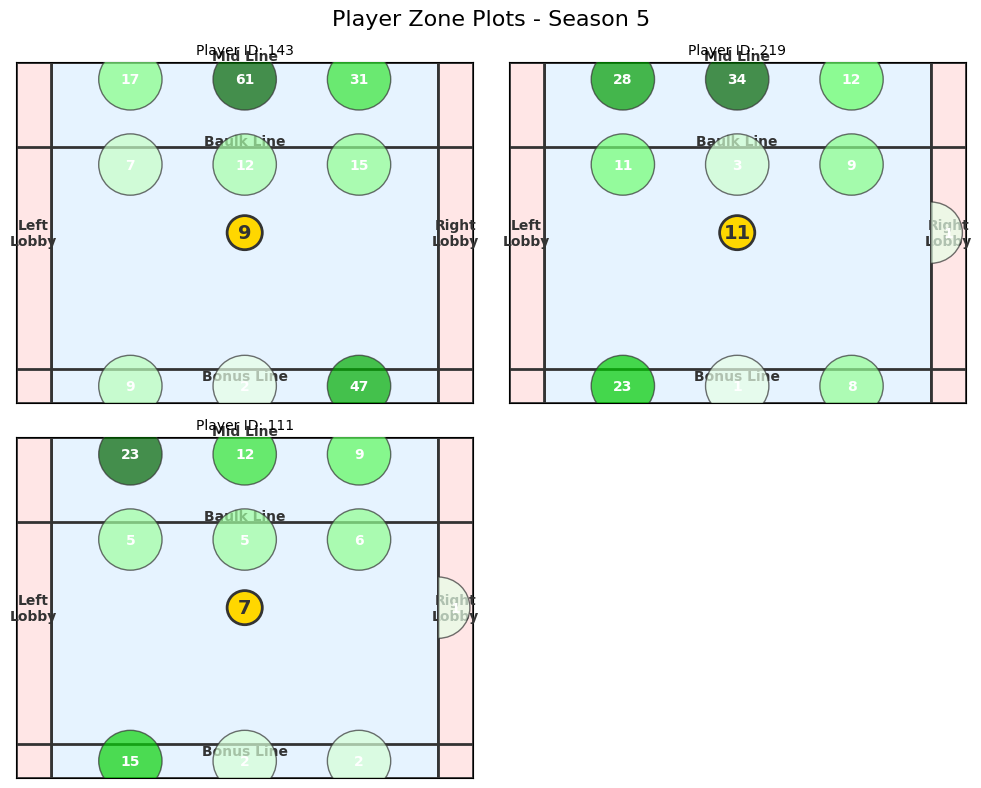

In [126]:
#create_player_zone_grid(column_list, season=5, zone_type='strong', grid_size=(4, 4))
plot_player_zones_grid(column_list, season=5, zone_type='strong', max_cols=2)


Player with ID 3176 not found in any match data.
Player with ID 621 not found in any match data.
Player with ID 3084 not found in any match data.


(<Figure size 600x400 with 1 Axes>, <Axes: >)

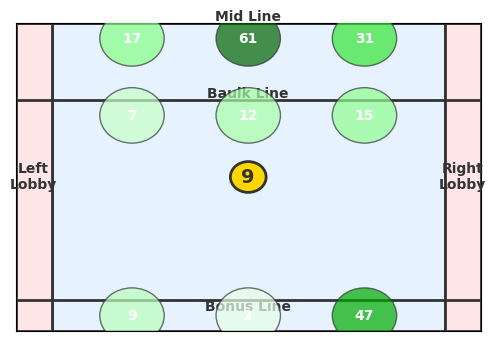

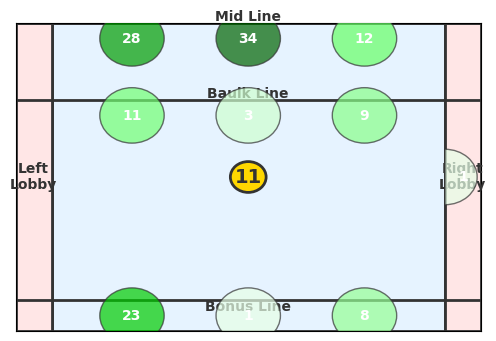

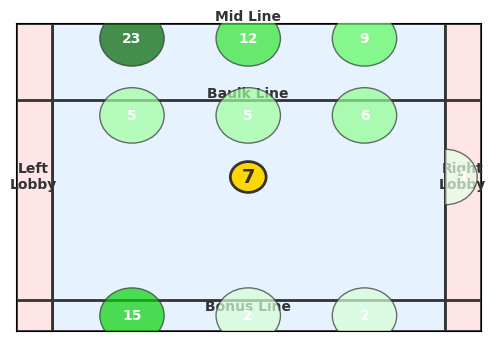

In [85]:
plot_player_zones_improved(143,season=5,zone_type='strong')
plot_player_zones_improved(3176,season=5,zone_type='strong')
plot_player_zones_improved(219,season=5,zone_type='strong')
plot_player_zones_improved(621,season=5,zone_type='strong')
plot_player_zones_improved(3084,season=5,zone_type='strong')
plot_player_zones_improved(111,season=5,zone_type='strong')


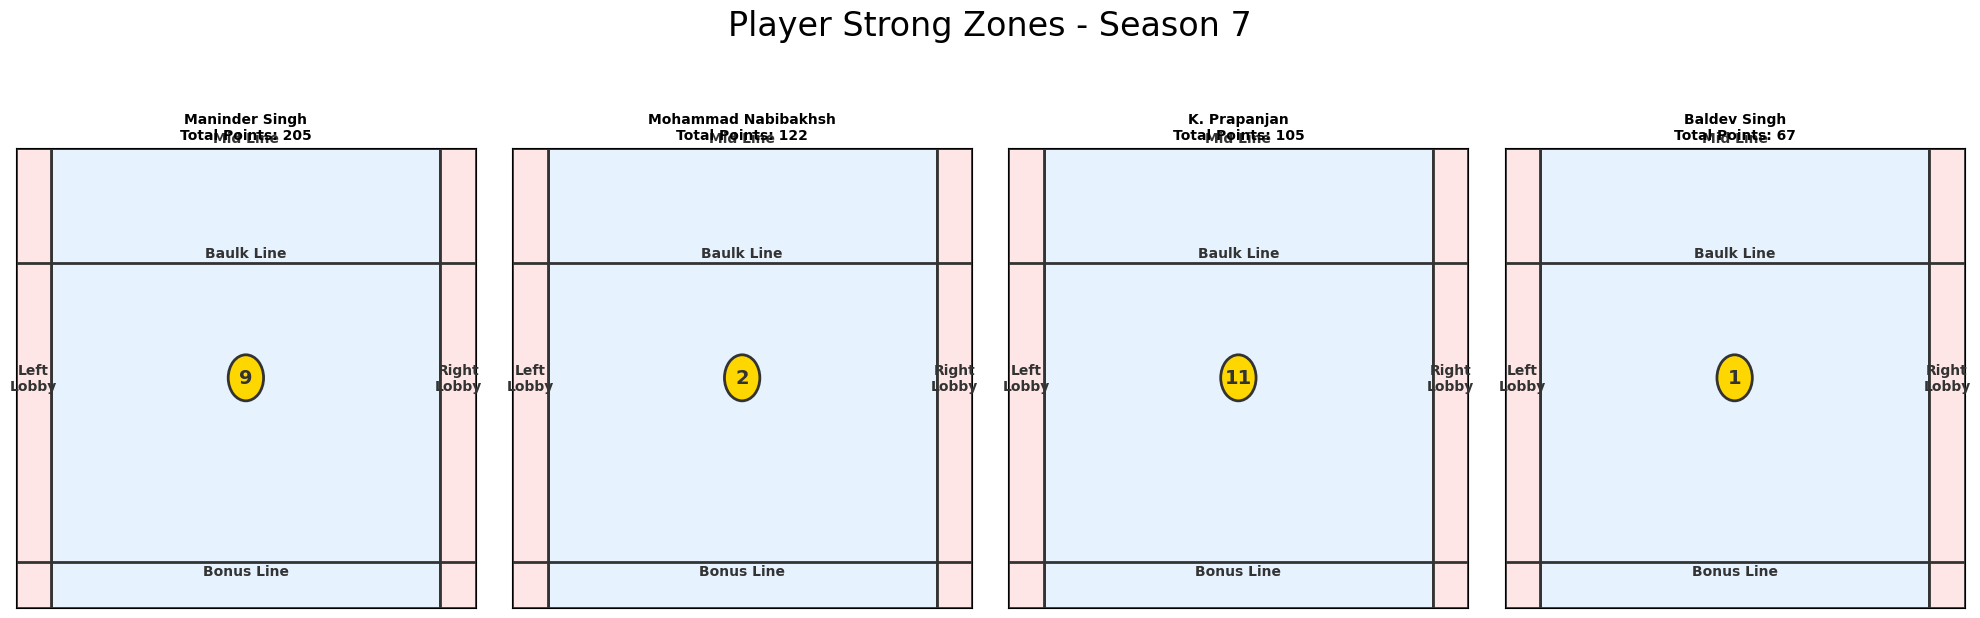

In [79]:
create_player_zone_subplots(df, season=7)  # Assuming season 7, adjust as needed
